In [1]:
import pandas as pd
from tqdm import tqdm
import seaborn as sns

## Get general statistics

In [2]:
ref=pd.read_pickle("../01_preparation/all_runs/tama_augustus_sqanti.pkl")

In [2]:
names=["tama_augustus","pb_augustus","tama_liftoff","pb_liftoff"]
runs=["../01_preparation/all_runs/tama_augustus_sqanti.pkl","../01_preparation/all_runs/pb_augustus_sqanti.pkl","../01_preparation/all_runs/tama_liftoff_sqanti.pkl","../01_preparation/all_runs/pb_liftoff_sqanti.pkl"]

rs_acc=pd.DataFrame()
rs_full_acc=pd.DataFrame()
rs_run=pd.DataFrame()
rs_run_acc=pd.DataFrame()

for name, run in zip(names,runs):
    # load full df
    ref=pd.read_pickle(f"{run}")
    # add new column
    ref["cat_assign"]="None"
    # and fill new colum based on 4 categories
    ref.loc[(ref["structural_category"] != "antisense") & (ref["structural_category"] != "fusion") & (ref["structural_category"] != "intergenic"), "cat_assign"]="one2one"
    ref.loc[(ref["structural_category"] == "antisense"), "cat_assign"]="antisense"
    ref.loc[(ref["structural_category"] == "fusion"), "cat_assign"]="fusion"
    ref.loc[(ref["structural_category"] == "intergenic") | (ref["structural_category"] == "genic_intron"), "cat_assign"]="novel"
    
    # in some cases, transcripts were reported as one2one even though the reads are spanning two genes.
    # In these cases, we have "fusion reads", but splicing results in perfect cds for one gene.
    # filter them and add replace the assignment
    ref["association"] = ref["associated_gene"].str.split("_").str.len()
    ref.loc[(ref["cat_assign"]=="one2one")&(ref["association"]>1), "cat_assign"] = "fusion"
    
    # add gene read support
    ref["cat_read_support"]=ref.groupby(by=["cat_assign","accession","gene"])["isoform_read_support"].transform("sum")

    #get read support per accession
    acc_read_contrib=ref[["gene","accession","cat_assign","cat_read_support"]]
    acc_read_contrib=acc_read_contrib.drop_duplicates()
    acc_read_contrib=acc_read_contrib.groupby(by=["accession"])["cat_read_support"].apply("sum").to_frame()
    acc_read_contrib.columns=[f"{name}_reads"]
    rs_acc=pd.concat([rs_acc, acc_read_contrib], axis=1)
    
    # get full rs table (reads-isoforms-genes)
    acc_full=ref[["gene","isoform","accession","cat_assign","cat_read_support"]]
    acc_isos=acc_full.groupby(by=["accession"]).apply(lambda x: len(x)).to_frame()
    acc_isos.columns=[f"{name}_isoforms"]
    acc_genes=acc_full.groupby(by=["accession"])["gene"].unique().apply(lambda x: len(x)).to_frame()
    acc_genes.columns=[f"{name}_genes"]
    rs_full_acc=pd.concat([rs_full_acc,acc_read_contrib,acc_isos,acc_genes], axis=1)

    # get read support per category
    run_read_contrib=ref[["gene","accession","cat_assign","cat_read_support"]]
    run_read_contrib=run_read_contrib.drop_duplicates()
    run_read_contrib=run_read_contrib.groupby(by=["cat_assign"])["cat_read_support"].apply("sum").to_frame()
    run_read_contrib.columns=[f"{name}"]
    rs_run=pd.concat([rs_run,run_read_contrib.T])
    
    #get read support per category per accession
    run_read_contrib_acc=ref[["gene","accession","cat_assign","cat_read_support"]]
    run_read_contrib_acc=run_read_contrib_acc.drop_duplicates()
    run_read_contrib_acc=run_read_contrib_acc.groupby(by=["cat_assign","accession"])["cat_read_support"].apply("sum").to_frame()
    run_read_contrib_acc.columns=["reads"]
    run_read_contrib_acc.reset_index(inplace=True)
    run_read_contrib_acc["run"]=f"{name}"
    rs_run_acc=pd.concat([rs_run_acc, run_read_contrib_acc])

In [7]:
rs_acc.to_csv("read_support_acc-vs-run.tsv", sep="\t")
rs_full_acc.to_csv("read_support-iso-gene_acc.tsv", sep="\t")
rs_run.to_csv("read_support_run-vs-category.tsv", sep="\t")
rs_run_acc.to_csv("read_support_run-vs-category_acc.tsv", sep="\t")

In [154]:
rs_full_acc.sort_values(by="pb_augustus_genes")

,tama_augustus_reads,tama_augustus_isoforms,tama_augustus_genes,pb_augustus_reads,pb_augustus_isoforms,pb_augustus_genes,tama_liftoff_reads,tama_liftoff_isoforms,tama_liftoff_genes,pb_liftoff_reads,pb_liftoff_isoforms,pb_liftoff_genes
accession,,,,,,,,,,,,
at8285,403367,156271,15553,418614,243135,15692,403367,156271,15553,418614,243135,15692
at9883,400109,150770,15734,413525,233336,15856,400109,150770,15734,413525,233336,15856
at9806,414876,157289,15780,427897,244684,15899,414876,157289,15780,427897,244684,15899
at9852,428249,165977,15879,443987,258923,16029,428249,165977,15879,443987,258923,16029
at9762,476400,180202,16157,491071,279749,16236,476400,180202,16157,491071,279749,16236
at6929,530863,187530,16128,550692,306330,16239,530863,187530,16128,550692,306330,16239
at9830,436827,165863,16203,452906,253973,16289,436827,165863,16203,452906,253973,16289
at9879,411709,160653,16274,424069,241421,16343,411709,160653,16274,424069,241421,16343
col0,480637,161844,16302,497329,268795,16432,480637,161844,16302,497329,268795,16432


In [13]:
rs_full_acc.columns

Index(['tama_augustus_reads', 'tama_augustus_isoforms', 'tama_augustus_genes',
       'pb_augustus_reads', 'pb_augustus_isoforms', 'pb_augustus_genes',
       'tama_liftoff_reads', 'tama_liftoff_isoforms', 'tama_liftoff_genes',
       'pb_liftoff_reads', 'pb_liftoff_isoforms', 'pb_liftoff_genes'],
      dtype='object')

In [116]:
samples=rs_full_acc[['tama_augustus_reads', 'tama_augustus_isoforms', 'tama_augustus_genes',
       'pb_augustus_reads', 'pb_augustus_isoforms', 'pb_augustus_genes']].reset_index()
samples.columns=['Accession','TAMA-reads', 'TAMA-isoforms', 'TAMA-genes','PB-reads', 'PB-isoforms', 'PB-genes']

In [137]:
p1_melt=samples.melt(id_vars="Accession", value_vars=['TAMA-isoforms', 'TAMA-genes','PB-isoforms', 'PB-genes'])

In [138]:
p1_melt["Collapsing-Tool"]=p1_melt["variable"].str.split("-").str[0]
p1_melt["Category"]=p1_melt["variable"].str.split("-").str[1]

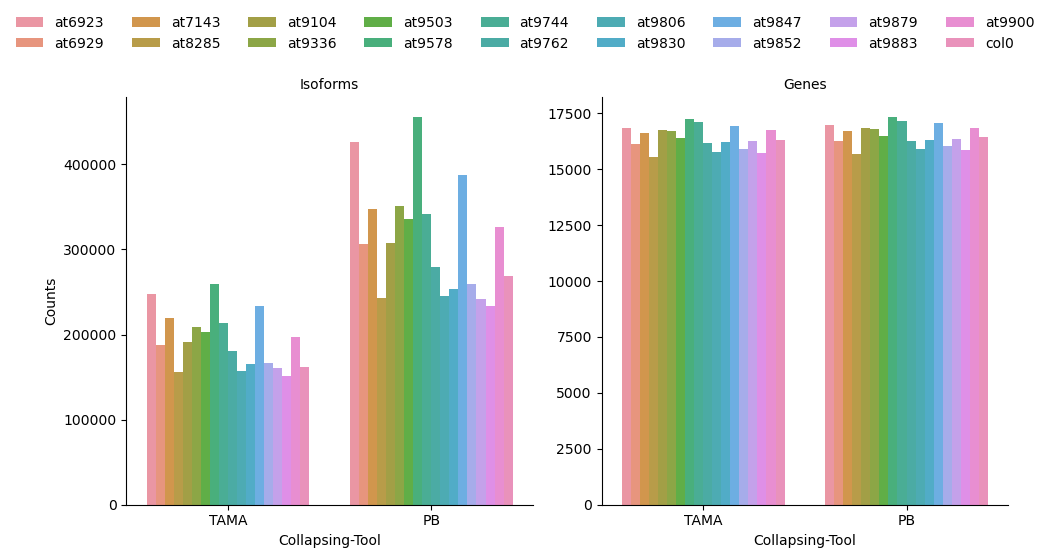

In [151]:
with sns.color_palette("colorblind"):
    p1=sns.catplot(p1_melt.replace({"reads":"Reads","isoforms":"Isoforms","genes":"Genes"}), x="Collapsing-Tool", y="value", hue="Accession",col="Category", kind="bar", sharey=False, col_wrap=2)

#p1.set_xlabels("Collapsing Tool")
p1.set_ylabels("Counts")

p1.set_titles(col_template="{col_name}")


#sns.move_legend(p1, "right",
#    bbox_to_anchor=(0.82, 0.25), ncols=2, title=None, frameon=False,
#)

sns.move_legend(p1, "center",
    bbox_to_anchor=(0.46, 1.06), ncols=9, title=None, frameon=False,
)

for ax in p1.axes:
    #ax.set_xticklabels(['TAMA', 'PB'], rotation=0)
    ax.tick_params(labelbottom=True)

In [152]:
fig = p1.fig
fig.savefig("prep_read_support-iso-gene_acc.png", bbox_inches='tight', dpi=200)

In [102]:
import pandas as pd
import matplotlib.pyplot as plt

# https://github.com/kartikay-bagla/bump-plot-python/blob/master/bumpplot.py

def bumpchart(df, show_rank_axis= True, rank_axis_distance= 1.1, 
              ax= None, scatter= False, holes= False,
              line_args= {}, scatter_args= {}, hole_args= {}):
    
    if ax is None:
        left_yaxis= plt.gca()
    else:
        left_yaxis = ax

    # Creating the right axis.
    right_yaxis = left_yaxis.twinx()
    
    axes = [left_yaxis, right_yaxis]
    
    # Creating the far right axis if show_rank_axis is True
    if show_rank_axis:
        far_right_yaxis = left_yaxis.twinx()
        axes.append(far_right_yaxis)
    
    for col in df.columns:
        y = df[col]
        x = df.index.values
        # Plotting blank points on the right axis/axes 
        # so that they line up with the left axis.
        for axis in axes[1:]:
            axis.plot(x, y, alpha= 0)

        left_yaxis.plot(x, y, **line_args, solid_capstyle='round')
        
        # Adding scatter plots
        if scatter:
            left_yaxis.scatter(x, y, **scatter_args)
            
            #Adding see-through holes
            if holes:
                bg_color = left_yaxis.get_facecolor()
                left_yaxis.scatter(x, y, color= bg_color, **hole_args)

    # Number of lines
    lines = len(df.columns)

    y_ticks = [*range(1, lines + 1)]
    
    # Configuring the axes so that they line up well.
    for axis in axes:
        axis.invert_yaxis()
        axis.set_yticks(y_ticks)
        axis.set_ylim((lines + 0.5, 0.5))
    
    # Sorting the labels to match the ranks.
    left_labels = df.iloc[0].sort_values().index
    right_labels = df.iloc[-1].sort_values().index
    
    left_yaxis.set_yticklabels(left_labels)
    right_yaxis.set_yticklabels(right_labels)
    
    # Setting the position of the far right axis so that it doesn't overlap with the right axis
    if show_rank_axis:
        far_right_yaxis.spines["right"].set_position(("axes", rank_axis_distance))
    
    return axes

In [97]:
tama=samples[["Accession","TAMA-reads","TAMA-isoforms","TAMA-genes"]]
idx = [*range(1, 19, 1)]
tama.index=idx
#tama.loc[tama["Accession"]=="at6923"].index.values.astype(int)[0]

2

In [110]:
rank={}
for i in tama["Accession"].tolist():
    rank[i]=[]
    
for i in ["TAMA-reads","TAMA-isoforms","TAMA-genes"]:
    t=tama.sort_values(by=i,ascending=False)
    t.index=idx
    for j in t["Accession"].tolist():
        rank[j].append(t.loc[t["Accession"]==j].index.values.astype(int)[0])

   Accession  TAMA-reads  TAMA-isoforms  TAMA-genes
1     at9578      840313         259671       17243
2     at6923      774246         247452       16832
3     at9847      702540         233811       16943
4     at9336      646294         208303       16709
5     at7143      610226         219206       16610
6     at9503      597735         203535       16383
7     at9744      589187         212969       17087
8     at9900      582580         197120       16754
9     at9104      556820         191366       16757
10    at6929      530863         187530       16128
11      col0      480637         161844       16302
12    at9762      476400         180202       16157
13    at9830      436827         165863       16203
14    at9852      428249         165977       15879
15    at9806      414876         157289       15780
16    at9879      411709         160653       16274
17    at8285      403367         156271       15553
18    at9883      400109         150770       15734
   Accession

In [112]:
df_rank = pd.DataFrame(rank, index=['Reads','Isoforms','Genes'])

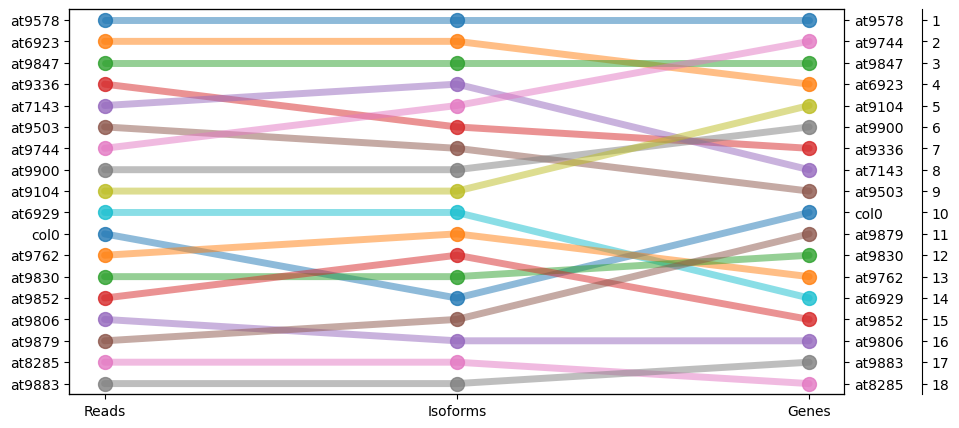

In [113]:
plt.figure(figsize=(10, 5))
bumpchart(df_rank, show_rank_axis= True, scatter= True, holes= False,
          line_args= {"linewidth": 5, "alpha": 0.5}, scatter_args= {"s": 100, "alpha": 0.8}) ## bump chart class with nice examples can be found on github
plt.show()
